# Open Exploration

This notebook is used for open exploration. We start by loading the data extracted from the python file dike_model_simulation_final_policy0.py. Then we perform several analyses. These are the following:

1. Exploring the Data
2. Preparing the Data for Analysis
3. PRIM analysis and Dimensional Stacking on 'Expected Annual Damage'
4. Combined PRIM analysis on 'Expected Annual Damage' and 'Expected Number of Deaths'
5. Creating the final DataFrame for Directed 

In [1]:
#import dependencies
import pandas as pd
from ema_workbench import load_results
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import ema_workbench.analysis.prim as prim
from ema_workbench.analysis import dimensional_stacking
from ema_workbench.analysis import parcoords



# Load the results
file_name = "data/dike_model_results_100k_experiments_id_7_plus_casualties.tar.gz"
experiments, outcomes = load_results(file_name)


In [22]:
outcomes

{'Expected Annual Damage': array([2.14254738e+08, 3.05047737e+09, 2.74103970e+09, ...,
        5.29388996e+08, 2.14464100e+09, 2.45142865e+09]),
 'Dike Investment Costs': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'RfR Investment Costs': array([0., 0., 0., ..., 0., 0., 0.]),
 'Expected Number of Deaths': array([0.17783088, 2.38224481, 1.95551976, ..., 0.49668138, 3.23729301,
        1.41254274])}

# Exploration of the Data

In [23]:
# Assuming outcomes['Expected Number of Deaths'] is a NumPy array
expected_deaths_array = outcomes['Expected Number of Deaths']

# Convert the array to a pandas DataFrame
df_expected_deaths = pd.DataFrame(expected_deaths_array, columns=['Expected Number of Deaths'])

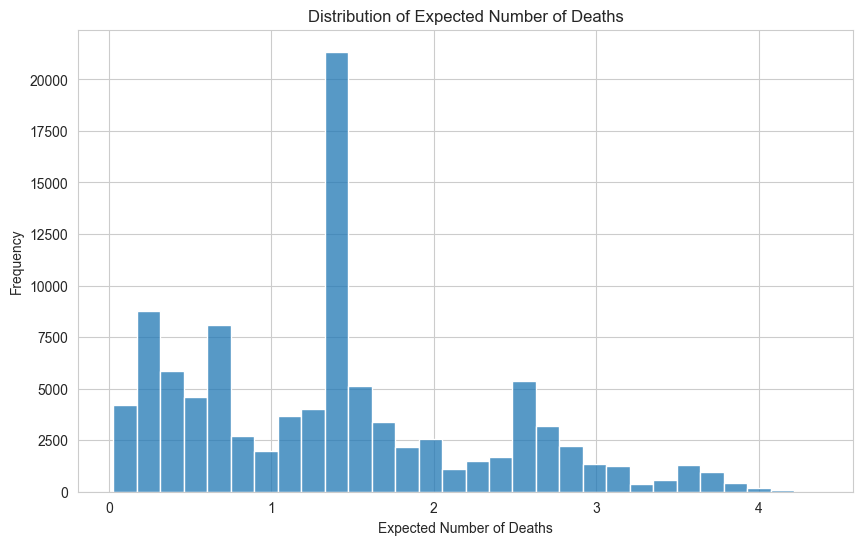

In [24]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a histogram to visualize the distribution of values
plt.figure(figsize=(10, 6))
sns.histplot(df_expected_deaths['Expected Number of Deaths'], bins=30, kde=False)

# Add labels and title
plt.xlabel('Expected Number of Deaths')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Number of Deaths')

# Show the plot
plt.show()

When running 100.000 experiments without any policy. A significant amount of the runs has at least one casualty. 

In [25]:
# Assuming outcomes['Expected Number of Deaths'] is a NumPy array
expected_damage_array = outcomes['Expected Annual Damage']

# Convert the array to a pandas DataFrame
df_expected_damage = pd.DataFrame(expected_damage_array, columns=['Expected Annual Damage'])

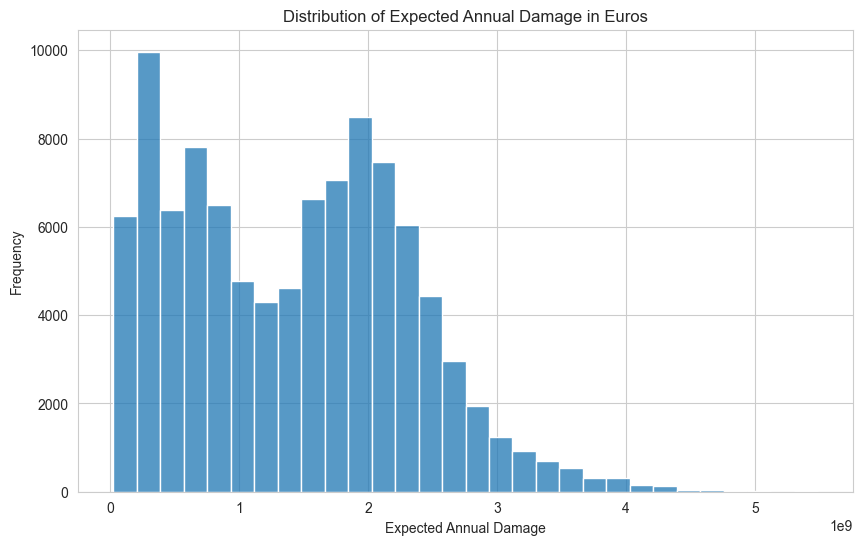

In [26]:
sns.set_style("whitegrid")

# Create a histogram to visualize the distribution of values
plt.figure(figsize=(10, 6))
sns.histplot(df_expected_damage['Expected Annual Damage'], bins=30, kde=False)

# Add labels and title
plt.xlabel('Expected Annual Damage')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Annual Damage in Euros')

# Show the plot
plt.show()

In [27]:
min_value = df_expected_damage['Expected Annual Damage'].min()
max_value = df_expected_damage['Expected Annual Damage'].max()

# Print the minimum value
print(f"The minimum value in 'Expected Annual Damages' is: {min_value}")
print(f"The max value in 'Expected Annual Damages' is: {max_value}")

The minimum value in 'Expected Annual Damages' is: 22133788.145161983
The max value in 'Expected Annual Damages' is: 5487739904.778571


In [28]:
expected_deaths_array = outcomes['Expected Number of Deaths']
expected_damages_array = outcomes['Expected Annual Damage']

# Convert the arrays to a pandas DataFrame
df_outcomes_exploration = pd.DataFrame({
    'Expected Number of Deaths': expected_deaths_array,
    'Expected Annual Damage': expected_damages_array
})

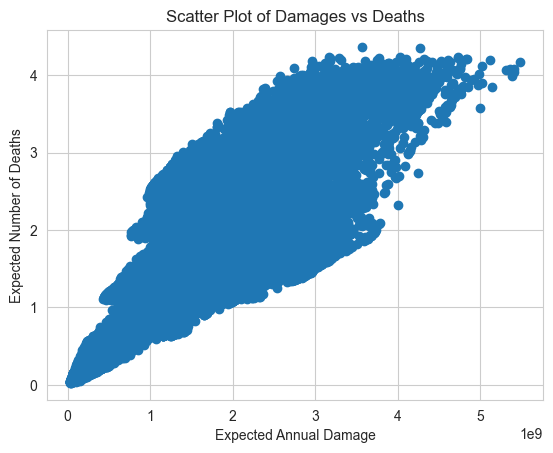

In [29]:
import matplotlib.pyplot as plt

# Scatter plot of Expected Annual Damages vs Expected Number of Deaths
plt.scatter(df_outcomes_exploration['Expected Annual Damage'], df_outcomes_exploration['Expected Number of Deaths'])
plt.xlabel('Expected Annual Damage')
plt.ylabel('Expected Number of Deaths')
plt.title('Scatter Plot of Damages vs Deaths')
#plt.savefig('scatter_damage_death.png', bbox_inches='tight')
plt.show()


The scatter plot proves that more damages leads to more casualties. 

## Conclusion on the exploration of the data

Without any form of policy the dike_model simulates damage in every experiment while at least one casualty (up to a maximum of four in some experiments) can be found in a significant amount of the cases. 

In [30]:
experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,3,254.902734,1.5,0.593971,32.557013,1.0,0.882012,161.253569,1.0,0.871676,...,0,0,0,0,0,0,0,0,Policy 0,dikesnet
1,31,152.243656,1.5,0.272982,238.928825,1.5,0.149486,289.339655,1.5,0.168840,...,0,0,0,0,0,0,0,1,Policy 0,dikesnet
2,113,30.712138,1.0,0.166951,267.319362,1.0,0.001443,211.871968,1.5,0.561197,...,0,0,0,0,0,0,0,2,Policy 0,dikesnet
3,60,58.934897,1.0,0.822042,269.146784,1.5,0.514214,246.951278,10.0,0.744889,...,0,0,0,0,0,0,0,3,Policy 0,dikesnet
4,103,210.370170,1.5,0.533631,219.285397,10.0,0.629098,65.398695,10.0,0.592146,...,0,0,0,0,0,0,0,4,Policy 0,dikesnet


In [31]:
experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [32]:
outcomes['Expected Annual Damage'] #as stated in problem formulation, we look at the annual damage of all the dike rings. i.e. the aggregation of expected annual damage for dike ring A1, A2, A3, A4, and A5. 


array([2.14254738e+08, 3.05047737e+09, 2.74103970e+09, ...,
       5.29388996e+08, 2.14464100e+09, 2.45142865e+09])

In [33]:
outcomes.keys() 

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Expected Number of Deaths'])

## Peparing the data for analysis

Since we will expore the uncertainty space to look for the most critical scenarios we are only considering the uncertainty values in the experiments DataFrame. In this part of the analysis we will prepare the data for scenario discovery. 

In [34]:
#maintain only the uncertainties
experiments_cleaned = experiments.iloc[:, :19]


In [35]:
experiments_cleaned.columns


Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2'],
      dtype='object')

In [36]:
#100.000 experiments. zero policy (1) x scenarios (100.000)
len(experiments_cleaned)

100000

## PRIM analysis

We have carried out two different PRIM analyses as part of the progress. We started with the Expected Annual Damage for our condition. We were not interested in the cost at this stage, as it is highly dependent on the policy implemented. However, after running the PRIM on Expected Annual Damage, we were not entirely satisfied with the results of this PRIM, so we decided to run another PRIM on both damages and casualties (Expected Number of Deaths). This PRIM produced more favourable results. We used this for further analysis.

### PRIM Analysis for Expected Annual Damage  

The target variable y for this analysis is set to 85. This means that we are interested in the scenarios in which the Expected Annual Damage is within the highest 15 percent.


The treshold is low, at 60 percent density. Any higher would result in one box. 

In [37]:
data = outcomes['Expected Annual Damage'] 

y = data > np.percentile(data, 85) # we are interested in the top 15% annual damage. 

prim_alg = prim.Prim(experiments_cleaned, y, threshold=0.60)
boxes = prim_alg.find_box()


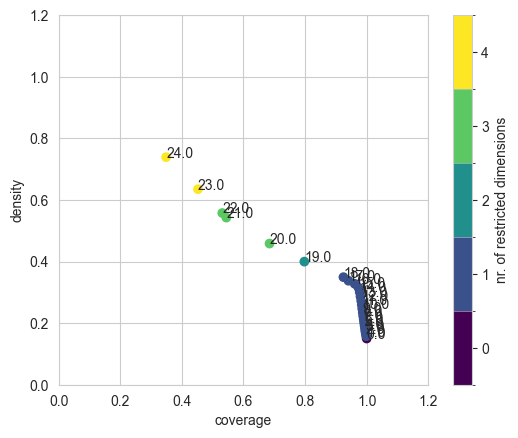

In [38]:
boxes.show_tradeoff(annotated=True)
plt.show()

Just looking at the top 15 expeted annual damage, the PRIM algorithm has difficulties finding boxes with high density. This means there is low predictive power considering there are many cases in the boxes that do not fit the condition of the target variable. The wide gaps on the x-axis tell us that the boxes have a high variability in data. 

In [39]:
point = 23 
boxes.inspect(point)

coverage        0.452400
density         0.634858
id             23.000000
k            6786.000000
mass            0.106890
mean            0.634858
n           10689.000000
res_dim         4.000000
Name: 23, dtype: float64

                          box 23                                         
                             min              max       qp value qp value
A.1_pfail                    0.0         0.376142            NaN      0.0
discount rate 1       {1.5, 2.5}       {1.5, 2.5}  2.830635e-261      NaN
discount rate 2  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   1.178838e-64      NaN
discount rate 0  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   1.198236e-59      NaN


C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 2.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1.5, 2.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


[None]

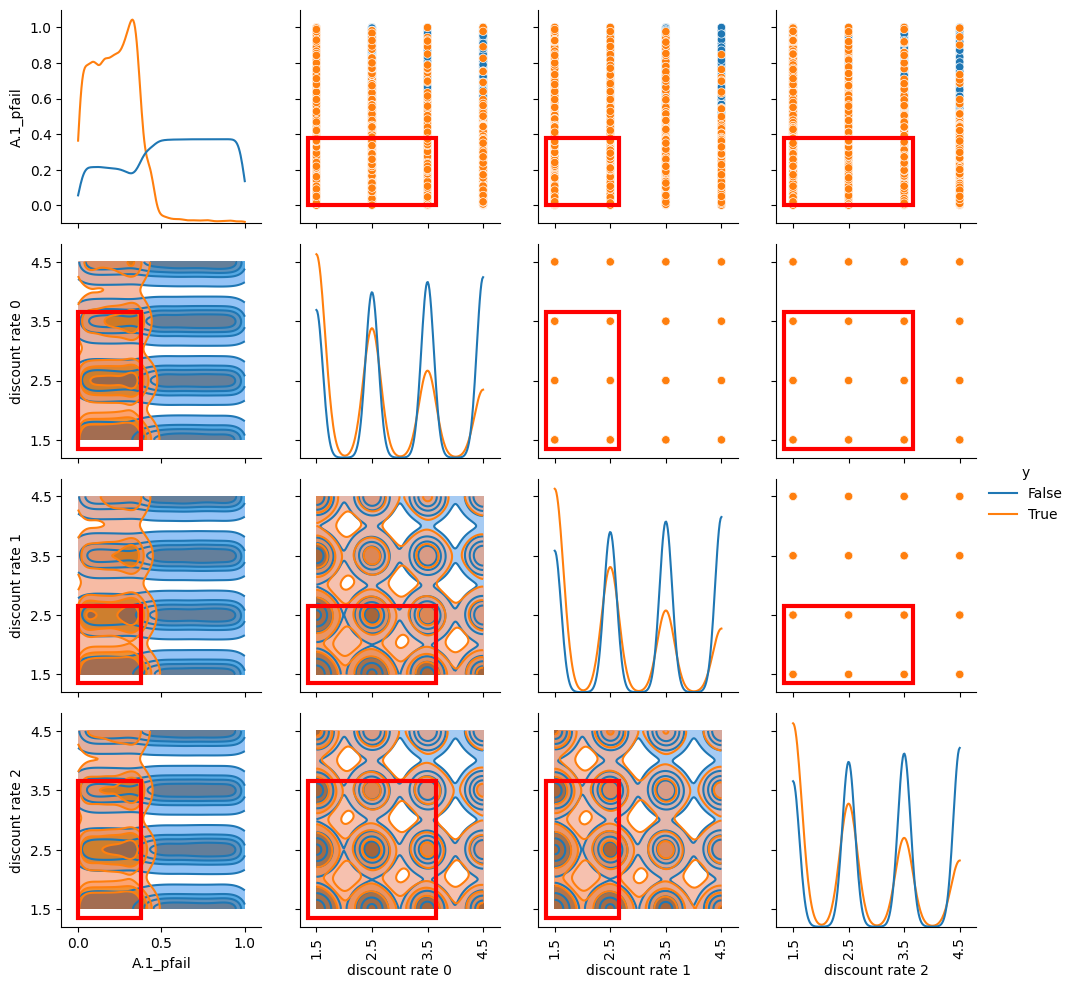

In [13]:
boxes.select(23)
fig = boxes.show_pairs_scatter()
#plt.title('Selected PRIM box with three restricted dimensions', y=3)
plt.show()

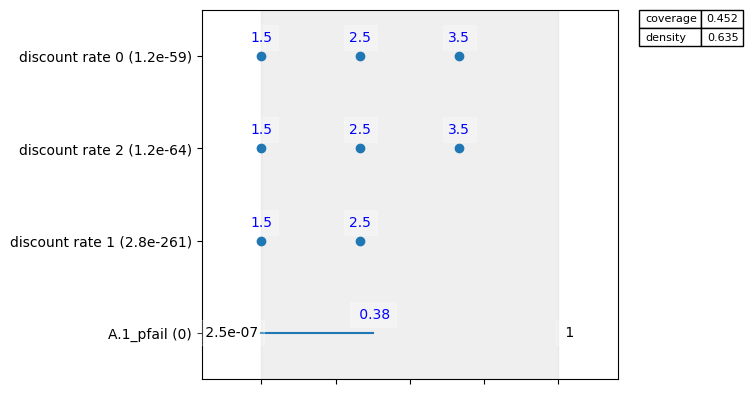

In [13]:
boxes.inspect(point, style='graph')
plt.show()


C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


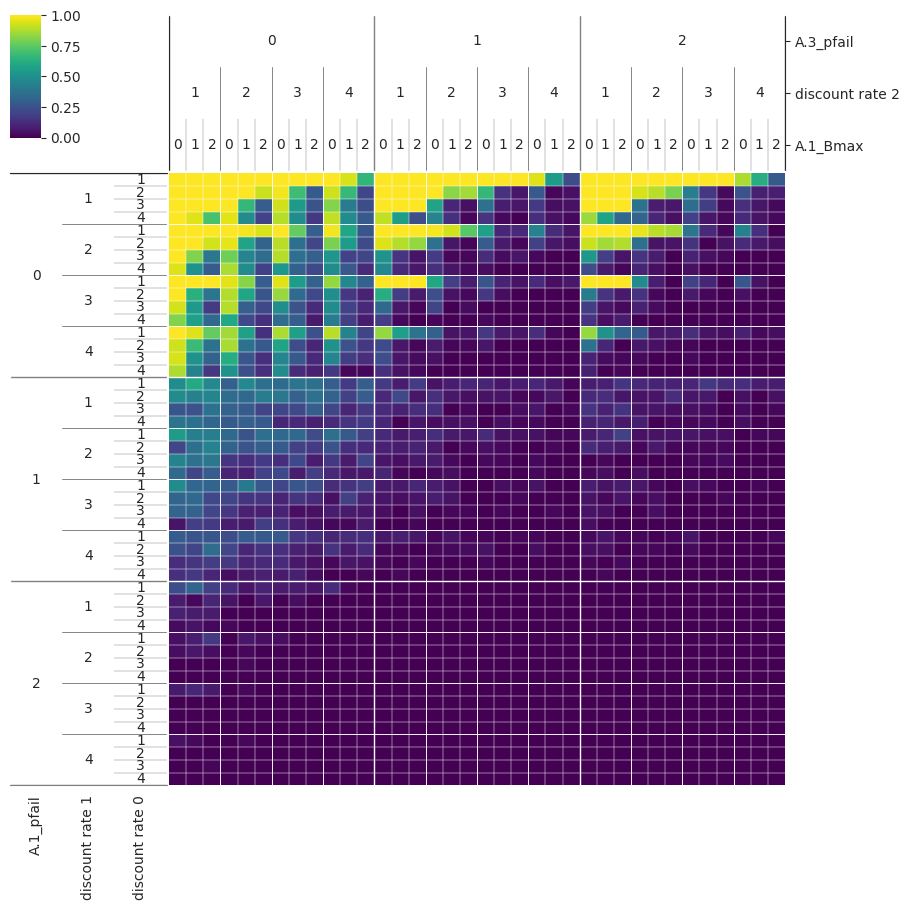

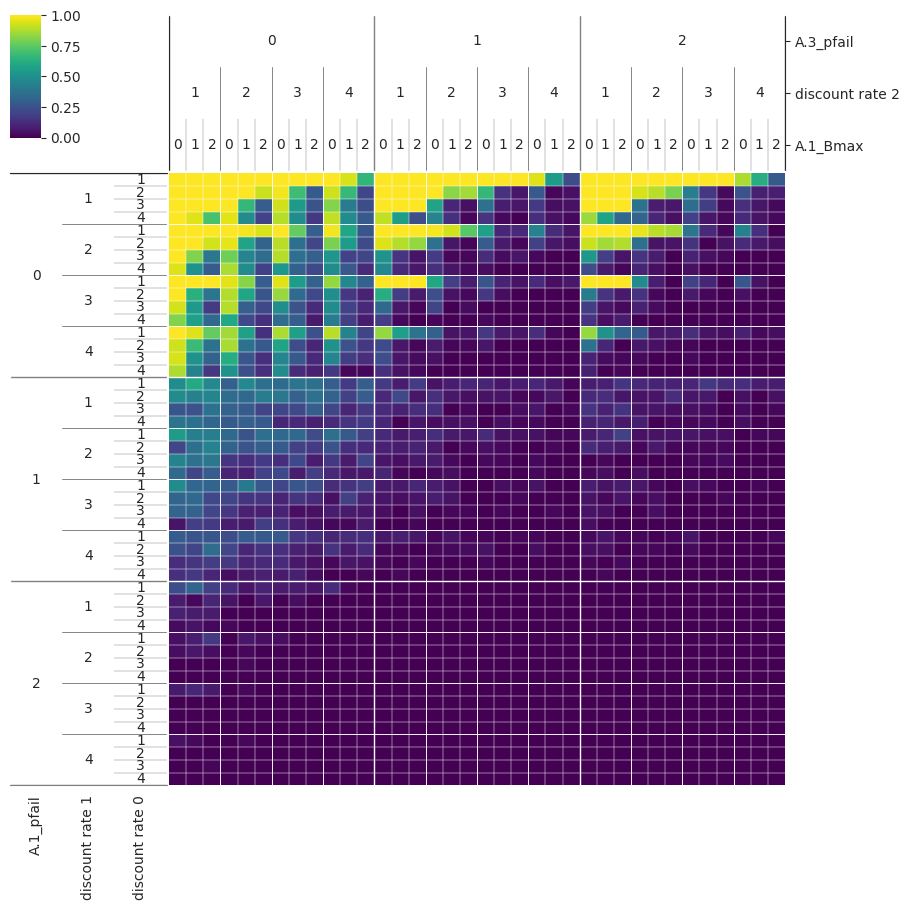

In [14]:
dimensional_stacking.create_pivot_plot(experiments_cleaned, y)

The results of the dimensional stacking above show that if A.1_pfail and discount rate 2 and 1 are low, the expected annual damage will be in the worst 15%. It can also be concluded that A.3_pfail and A.1_bmax do not strongly influence the expected annual damage, as they perform similarly on all three levels. 

## Conclusion first PRIM

The first prim does not provide a clear subgroup of experiments that can explain a certain rule which applies for all the scenarios in the box. We therefore try to add more data and see if it works better. 

### Combined PRIM analysis Expected Annual Damage and Expected Number of Deaths

There are very little casualties when the IJssel river floods, which is why we at first picked expected annual damage as our sole target variable for the PRIM analysis. Of course, it is the duty of Water Board 3 to keep the number of casualties zero at all times but it is more realistic that they are concerned with the expected annual damages as they are significant each time the river floods. In the end, to come up with a good PRIM analysis that satisfied our needs, we combined them both. 

For the combined analysis the target variables expected annual damages is set at 85 and expected anual death is set to 90. This threshold is slightly higher than that for Expected Annual Damage. We have chosen this because Expected Annual Damage is more important to Water Board 3 than Expected Number of Deaths. We are therefore interested in policies that cover a wider range of bad scenarios for Expected Annual Damage. 

In [40]:
import ema_workbench.analysis.prim as prim
damage_data = outcomes['Expected Annual Damage']
casualties_data = outcomes['Expected Number of Deaths']

damage_threshold = np.percentile(damage_data, 85)
casualties_threshold = np.percentile(casualties_data, 90)

# Create a combined condition
combined_condition = (damage_data > damage_threshold) & (casualties_data > casualties_threshold)

# Perform PRIM analysis using the combined condition
prim_alg = prim.Prim(experiments_cleaned, combined_condition, threshold=0.65)
boxes2 = prim_alg.find_box()

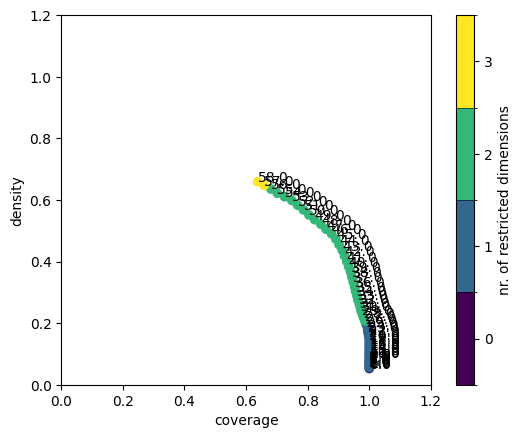

In [21]:
boxes2.show_tradeoff(annotated=True)
plt.show()

In [23]:
point2 = 54
boxes2.inspect(point2)

coverage       0.724858
density        0.610321
id            54.000000
k           3820.000000
mass           0.062590
mean           0.610321
n           6259.000000
res_dim        2.000000
Name: 54, dtype: float64

             box 54                            
                min       max qp value qp value
A.3_pfail  0.000003  0.150470      NaN      0.0
A.1_pfail  0.021553  0.445218  0.02969      0.0


[None]

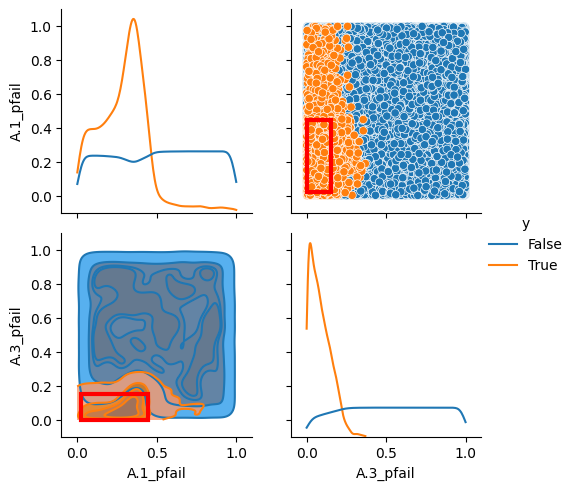

In [24]:
boxes2.select(54)
fig = boxes2.show_pairs_scatter()

plt.show()

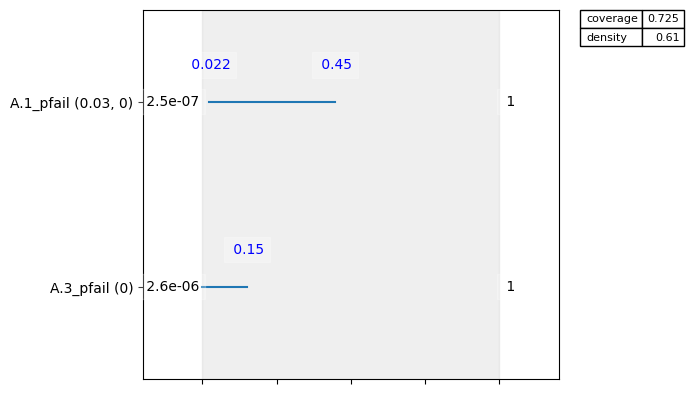

In [25]:
boxes2.inspect(point2, style='graph')
plt.show()


C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


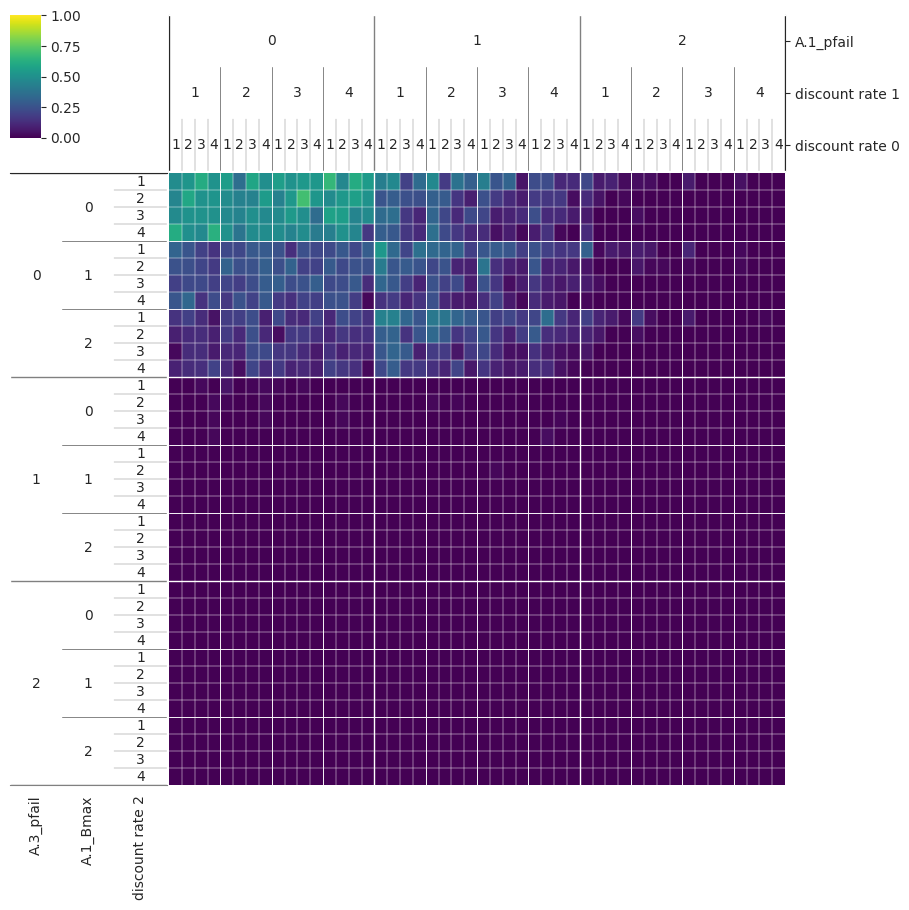

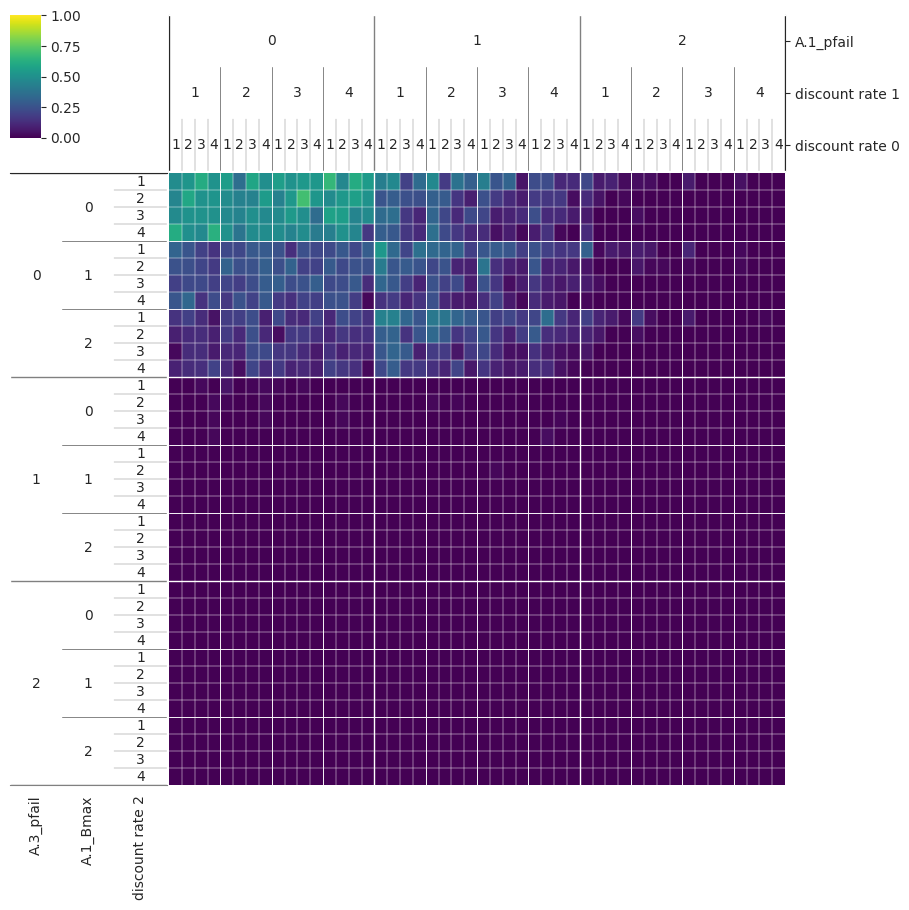

In [28]:
dimensional_stacking.create_pivot_plot(experiments_cleaned, combined_condition)

This Dimensional Stacking analysis shows that a low value for A3_pfail, A1_Bmax and A1_pfail contributes strongly to the 'worst case' scenarios. 

## Conclusion on final PRIM

Box 54 identifies a subset of experiments that define a good set based on constraints set for the target variables, achieving 61% density and 72% coverage. However, the PRIM box is a narrative descriptor. The box gives a qualitive explanation for the scenario of interest associated with the bad outcome. It's important to understand that PRIM is just a tool for analysing experiments that meet certain criteria within a defined rule or box. Simply selecting a box and using those experiments for further analysis is not considered best practice.

To address this, we used the two conditions based on the target variables that we provided to the PRIM algorithm to filter the original dataframe of 100,000 experiments. This approach ensures a more robust and comprehensive analysis.

The constraint provided us with 5270 experiments, which we then had to reduce even further. For this we used K-means and set the amount of clusters to 5. We picked the experiment which was closest to the centroid of each cluster to come up with a set of five distinct experiments, which we call scenarios based on the fact that they are ran on a zero policy.

## Creating the Final DataFrame for Directed Search

In [41]:
# Define the conditions used for PRIM
damage_data = outcomes['Expected Annual Damage']
casualties_data = outcomes['Expected Number of Deaths']

# Define the top 15% threshold for both outcomes
damage_threshold = np.percentile(damage_data, 85)
casualties_threshold = np.percentile(casualties_data, 90)

# Filter experiments based on the conditions used for PRIM
selected_experiments = experiments_cleaned[(outcomes['Expected Annual Damage'] >= damage_threshold) &
                                           (outcomes['Expected Number of Deaths'] >= casualties_threshold)]

# Convert to DataFrame if not already
selected_experiments_df1 = pd.DataFrame(selected_experiments)
selected_experiments_df1

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
15,117,264.113834,10.0,0.327932,345.636685,10.0,0.505215,46.505229,1.5,0.100802,211.004889,1.5,0.223988,53.816691,1.0,0.793040,3.5,3.5,3.5
76,11,44.422724,1.5,0.132542,118.733035,1.0,0.366349,98.840820,1.5,0.093174,147.602548,1.0,0.963360,279.094070,1.0,0.803029,3.5,3.5,2.5
96,61,274.565373,1.0,0.464169,52.530371,10.0,0.122425,335.976136,10.0,0.149216,99.949358,1.0,0.207592,340.809928,10.0,0.410907,1.5,2.5,4.5
114,7,241.278976,10.0,0.259171,113.175678,1.5,0.840056,68.255217,1.5,0.061911,226.711217,1.5,0.060271,170.557454,1.0,0.423180,3.5,2.5,1.5
127,60,43.959094,10.0,0.329381,125.035074,10.0,0.495658,232.230371,1.5,0.074962,295.407180,1.0,0.043658,231.258563,1.5,0.086405,2.5,4.5,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99934,94,68.227608,1.5,0.188902,96.553739,1.5,0.278866,163.137555,10.0,0.072573,306.209623,10.0,0.839452,322.518823,1.0,0.698616,1.5,1.5,3.5
99950,80,257.009007,10.0,0.306472,98.957703,1.5,0.064534,291.271929,1.0,0.183570,287.275892,1.5,0.688367,323.625752,1.5,0.560837,1.5,2.5,4.5
99953,121,72.814073,1.5,0.183846,87.190091,10.0,0.244051,136.130277,10.0,0.244913,222.943241,1.0,0.762861,286.828911,1.5,0.003774,2.5,4.5,3.5
99966,40,189.519774,1.5,0.877412,103.349235,1.5,0.122239,241.486308,1.5,0.169700,332.568246,1.0,0.984174,276.085711,1.5,0.317576,1.5,1.5,1.5


In [42]:
selected_experiments_df1.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2'],
      dtype='object')

In [43]:
# Select the columns to plot
columns_to_plot = [
    'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
    'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
    'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
    'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
    'discount rate 2'
]

# Select only the specified columns from the DataFrame
parcoords_df = selected_experiments_df1[columns_to_plot]

# Check the data types
print(parcoords_df.dtypes)

# Convert categorical columns to numeric if necessary
for column in parcoords_df.columns:
    if parcoords_df[column].dtype.name == 'category':
        parcoords_df[column] = parcoords_df[column].cat.codes

# Ensure all columns are numeric
print(parcoords_df.dtypes)



A.0_ID flood wave shape       int32
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
dtype: object
A.0_ID flood wave shape      int32
A.1_Bmax                   float64
A.1_Brate                     int8
A.1_pfail                  float64
A.2_Bmax                   float64
A.2_Brate                     int8
A.2_pfail                  float64
A.3_Bmax                   float64
A.3_Brate             

### Parcoords plots

The first parcoord plot is difficult to read since it contains way to much data. A policy maker would not understand. We will therefore reduce it using k-means clustering. 

<Figure size 1200x800 with 0 Axes>

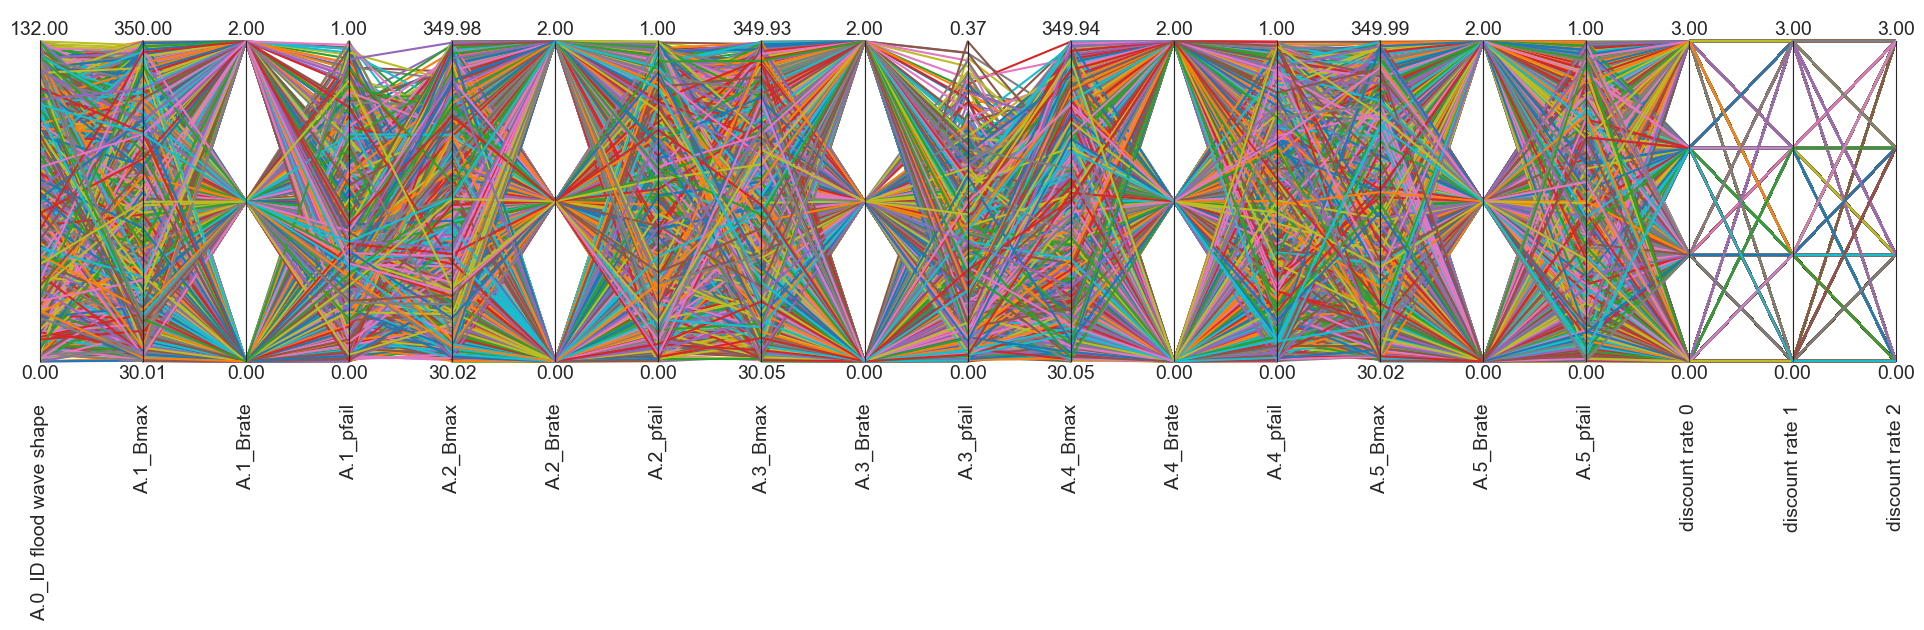

In [44]:

limits = parcoords.get_limits(parcoords_df)
plt.figure(figsize=(12, 8))
axes = parcoords.ParallelAxes(limits)
axes.plot(parcoords_df)
plt.subplots_adjust(left=0.1, right=3, top=0.9, bottom=0.1)
plt.show()

In [45]:
outcomes = parcoords_df

# Normalize the data
scaler = StandardScaler()
outcomes_normalized = scaler.fit_transform(outcomes)

# Apply K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(outcomes_normalized)

# Find the sample closest to each centroid
closest_samples = []
for i in range(kmeans.n_clusters):
    cluster_mask = labels == i
    distances = kmeans.transform(outcomes_normalized)[:, i]
    closest_sample_index = np.argmin(distances[cluster_mask])
    closest_samples.append(cluster_mask.nonzero()[0][closest_sample_index])

# Extract the closest samples from the original data
closest_samples_data = outcomes.iloc[closest_samples]

<Figure size 1200x800 with 0 Axes>

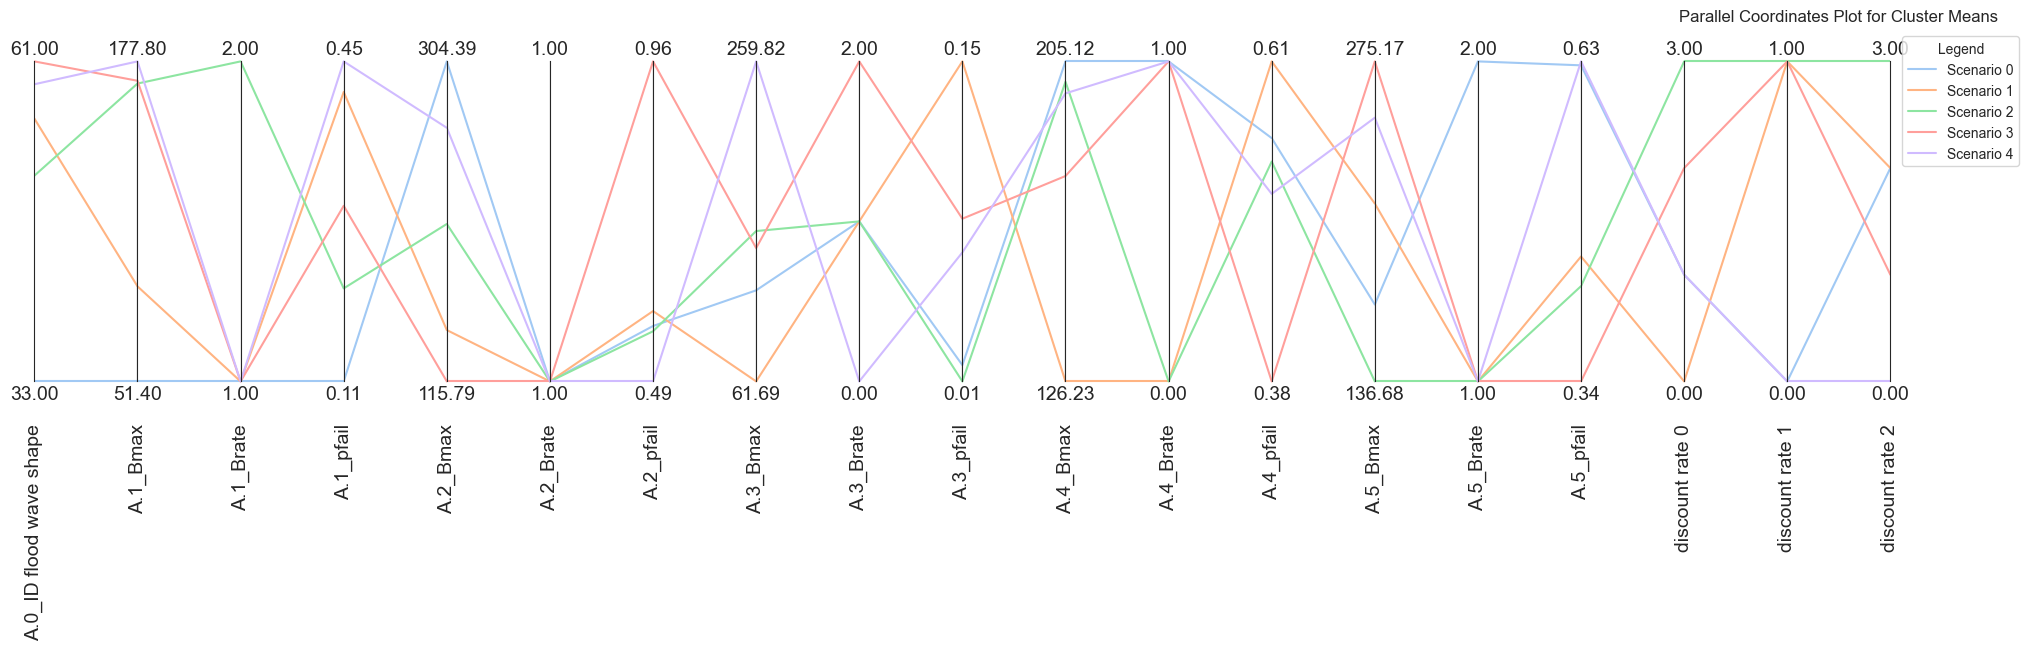

In [46]:
closest_samples_data = closest_samples_data.reset_index(drop=True)

# Plot the means of each cluster using parallel coordinates
colors = sns.color_palette("pastel", len(closest_samples_data))
plt.figure(figsize=(12, 8))
limits = parcoords.get_limits(closest_samples_data)
axes = parcoords.ParallelAxes(limits)

# Create a list of labels for the legend
legend_labels = []

for i, (index, row) in enumerate(closest_samples_data.iterrows()):
    color = sns.color_palette("pastel", len(closest_samples_data))[i]
    axes.plot(row.to_frame().T, label=str(index), color=color)
    legend_labels.append(f'Scenario {index}')

# Manually create the legend using plt.legend()
plt.legend(title='Legend', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='best')

plt.title('Parallel Coordinates Plot for Cluster Means')
plt.subplots_adjust(left=0.1, right=3, top=0.9, bottom=0.1)
#plt.savefig('final_5_scenarios.png', bbox_inches='tight')
plt.show()

The final five scenarios are plotted over all the uncertainties showing the distinct profile created with the k means algorithm. These final five scenario will be used during direct search. 

In [47]:
#Final dataframe with scenarios that are going to be used in the directed search

final_scenarios = pd.DataFrame(closest_samples_data)
final_scenarios.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,33,51.396726,1,0.112822,304.388564,1,0.572887,118.070695,1,0.016500,205.115473,1,0.557517,169.955614,2,0.623157,1,0,2
1,56,88.943712,1,0.419939,146.040737,1,0.594711,61.691926,1,0.150177,126.225806,0,0.612236,213.647861,1,0.451739,0,1,2
2,51,169.050860,2,0.211516,208.575735,1,0.565192,154.785103,1,0.009327,200.094119,0,0.540791,136.684868,1,0.425170,3,1,3
3,61,170.158276,1,0.299122,115.789755,1,0.959847,144.253538,2,0.080931,176.857729,1,0.383973,275.165239,1,0.339744,2,1,1
4,59,177.799972,1,0.452371,265.248377,1,0.491867,259.818074,0,0.066098,197.232907,1,0.517739,250.800261,1,0.626679,1,0,0


In [ ]:
#final_scenarios.to_csv('final_scenarios_final.csv', index=False)